<a href="https://colab.research.google.com/github/danangcrysnanto/bovine-graphs-mapping/blob/master/part4_variantgenotyping/analysis/part4_variantgenotyping_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Part4 Variant genotyping from whole genome graphs

In this part, we constructed whole genome graphs for Brown Swiss population, by augmenting ~14.1 M autosomal variants identified from 82 Brown Swiss to the Bovine UCD1.2 Hereford reference.

We then mapped 10 samples (not used for simulation) to this whole genome graph.
We then compared with mapping with linear genome using bwa or vg (empty graphs, only backbone without variations).

In [0]:
library(tidyverse)
library(magrittr)

In [0]:
## We download data from github with this base url 
basepath <- "https://raw.githubusercontent.com/danangcrysnanto/bovine-graphs-mapping/master/part4_variantgenotyping/result/"

### Comparison between unique and perfect mapping

Since reads were not simulated, we could not assess the mapping correctnes. Then, we followed previous approach in Novak et al. (2017), Prit et al. (2018) to calculate the reads that map perfectly (edit distance 0 without clipping) and reads that map uniquely, meaning that there is only single map location, or considerably high MQ (MQ=60) in case of multi-mapping

In [0]:
datunper  <- read.table(url(file.path(basepath,"datuniqperf.tsv")),header=TRUE)
head(datunper)

,anims,chromosome,perfect,uniq,mapped,mapper
,<fct>,<int>,<int>,<int>,<int>,<fct>
1,SAMEA6163185,26,10279313,16903241,18683273,bwa
2,SAMEA6163185,25,8309298,14221373,15292823,bwa
3,SAMEA6163185,23,10110907,17452679,19451742,bwa
4,SAMEA6163185,22,12488501,20006120,21333175,bwa
5,SAMEA6163185,27,9233937,15010304,16139287,bwa
6,SAMEA6163185,29,10237165,17491148,21479025,bwa


In [0]:
#since the data is per chromosome, then we combined across 
datunper_sum <- datunper %>% group_by(anims,mapper) %>% summarise(perfect=sum(perfect)*100/sum(mapped),
                                                            uniq=sum(uniq)*100/sum(mapped))

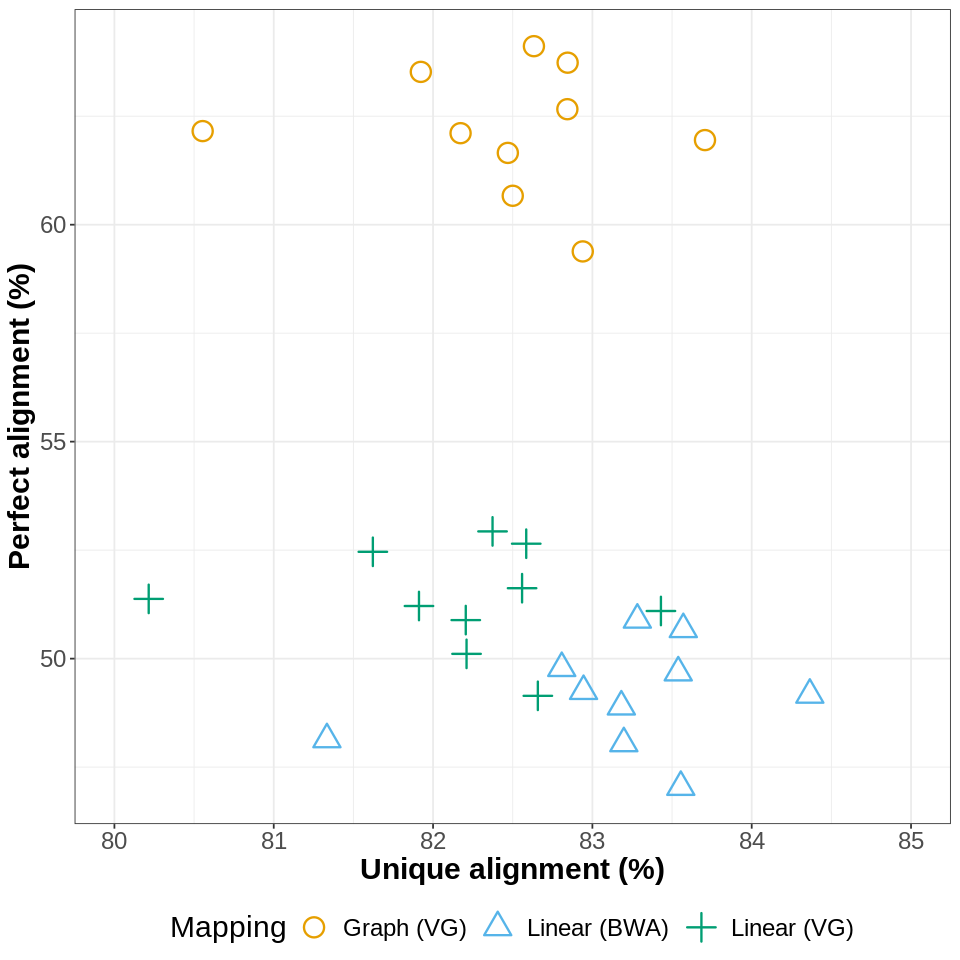

In [0]:
options(repr.plot.width=8, repr.plot.height=8)
datunper_sum %<>% mutate(Mapping=case_when(mapper=="bwa"~"Linear (BWA)",
                                     mapper=="vg_linear"~"Linear (VG)",
                                     mapper=="vg_graph"~ "Graph (VG)"))

ggplot(datunper_sum,aes(x=uniq,y=perfect,col=Mapping,shape=Mapping)) +
  geom_point(size=5,stroke=1)+
  scale_color_manual(values=c("#E69F00", "#56B4E9", "#009E73"))+
  scale_shape_manual(values=c(1,2,3))+
  theme_bw()+
  labs(x="Unique alignment (%)",y="Perfect alignment (%)",fill="Alignment")+
  coord_cartesian(xlim = c(80,85))+
  theme(text=element_text(size=18),
        axis.title = element_text(face="bold"),
        legend.position = "bottom")

### Quantify the difference across mapping scenarios

In [0]:
## The largest improvement is in the perfect mapping to the paths in the graphs
## We need to quantify this
datperf <- datunper_sum %>% select(anims,perfect,mapper) %>% pivot_wider(names_from = mapper,values_from = perfect) %>% 
          mutate(dif=vg_graph-bwa)
cat("Maximum improvement in perfect mapping in the graph alignment from linear BWA")
max(datperf$dif)
cat("Minimum improvement in perfect mapping in the graph alignment from linear BWA")
min(datperf$dif) 
cat("Mean improvement in perfect mapping in the graph alignment from linear BWA")
mean(datperf$dif)

Maximum improvement in perfect mapping in the graph alignment from linear BWA

[1] 14.01809

Minimum improvement in perfect mapping in the graph alignment from linear BWA

[1] 12.34316

Mean improvement in perfect mapping in the graph alignment from linear BWA

[1] 13.03827

In [0]:
## However we noticed that the unique mapping is decreased (but very small) in graph alignments
datuniq <- datunper_sum %>% select(anims,uniq,mapper) %>% pivot_wider(names_from = mapper,values_from = uniq) %>% 
  mutate(dif=vg_graph-bwa)
cat("Minimum decreased in uniq mapping in the graph alignment from linear BWA")
max(datuniq$dif)
cat("Maximum decreased in uniq mapping in the graph alignment from linear BWA")
min(datuniq$dif) 
cat("Mean decreased in uniq mapping in the graph alignment from linear BWA")
mean(datuniq$dif)

Minimum decreased in uniq mapping in the graph alignment from linear BWA

[1] -0.6153294

Maximum decreased in uniq mapping in the graph alignment from linear BWA

[1] -0.8844619

Mean decreased in uniq mapping in the graph alignment from linear BWA

[1] -0.7190196

### Comparison of the genotypes discovered from linear vs graph alignments

We then surjected the graph alignment to the corresponding linear coordinates. 
We then used the samtools multi-sample calling to call variants.
Finally, we compared with the matched SNP array to calculate concordance statistics as below.

![Concordance statistics](https://github.com/danangcrysnanto/bovine-graphs-mapping/blob/master/part4_variantgenotyping/analysis/concor_stat.png?raw=1)

In [0]:
## Statistics of concordance for samtools
## Mode indicate the mapping mode, bwa, graph, or vg(linear)
## Fil indicate the filtered or raw genotypes

datsam  <- read.table(url(file.path(basepath,"samtools_concordance_all.tsv")),header=TRUE)  %>% select(-prog)
head(datsam)

,anims,mode,type1,type2,type3,type4,type5,type6,type7,type8,type9,type10,type11,type12,concor,recal,discre,concor_het,concor_alt,precision
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SAMEA6163185,bwa_fil,151225,552,16,63,185563,84,19,65,196616,138978,2897,7329,99.85043,97.39877,0.2085208,99.66860,99.94917,99.93959
2,SAMEA6163185,bwa,153899,670,21,64,186106,101,19,111,201835,136303,2190,2088,99.81836,98.91179,0.2533885,99.58210,99.93959,99.92402
3,SAMEA6163185,graph_fil,151172,523,12,62,185528,78,19,68,196373,139032,2958,7582,99.85726,97.31890,0.1990283,99.68246,99.95419,99.94060
4,SAMEA6163185,graph,153882,632,16,64,186121,89,19,113,201762,136320,2211,2178,99.82808,98.88355,0.2398367,99.60132,99.94799,99.92658
5,SAMEA6163185,linear_fil,151011,565,18,61,185465,89,19,65,196348,139194,2982,7590,99.84690,97.31076,0.2134122,99.66146,99.94553,99.93875
6,SAMEA6163185,linear,153776,694,24,63,186073,106,19,108,201814,136427,2202,2101,99.81315,98.90543,0.2606016,99.57084,99.93563,99.92375


In [0]:
## Since the statistics calculated based on each animals, 
## We take mean and sd to report the performance of each caller

datsam %>% group_by(mode) %>% summarise(m_concor=mean(concor),
                                        sd_concor=sd(concor),
                                        m_recall=mean(recal),
                                        sd_recall=sd(recal),
                                        m_discre=mean(discre),
                                        sd_discre=sd(discre),
                                        m_precision=mean(precision),
                                        sd_precision=sd(precision)) %>% as.data.frame()

mode,m_concor,sd_concor,m_recall,sd_recall,m_discre,sd_discre,m_precision,sd_precision
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bwa,98.53338,1.034045,98.53321,0.3891519,2.167447,1.547683,98.92639,0.8087209
bwa_fil,98.55631,1.046630,97.53251,0.3519778,2.131694,1.563001,98.93616,0.8157463
graph,98.50106,1.062937,98.52945,0.3737168,2.215406,1.590435,98.89641,0.8247129
graph_fil,98.52672,1.070207,97.48387,0.3564649,2.175410,1.598042,98.90657,0.8329487
linear,98.47935,1.069830,98.52661,0.3890434,2.247084,1.601042,98.89383,0.8258252
linear_fil,98.50901,1.079570,97.45793,0.3492561,2.201377,1.611964,98.90373,0.8372068


Almost no difference among tools, we can plot it to see the pattern more clear

### Plot of the genotype concordance across sequencing depth

We test whether there is any difference across sequencing coverage between graphs and linear alignment.

In [0]:
options(warn=-1)
datcov <- read.table(url(file.path(basepath,"anims_coverage.tsv")),header=FALSE)
colnames(datcov) <- c("anims","coverage")


datsamall <- datsam %>% left_join(datcov,by=c("anims"))
head(datsamall)

,anims,mode,type1,type2,type3,type4,type5,type6,type7,type8,⋯,type10,type11,type12,concor,recal,discre,concor_het,concor_alt,precision,coverage
,<chr>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,SAMEA6163185,bwa_fil,151225,552,16,63,185563,84,19,65,⋯,138978,2897,7329,99.85043,97.39877,0.2085208,99.66860,99.94917,99.93959,39.88
2,SAMEA6163185,bwa,153899,670,21,64,186106,101,19,111,⋯,136303,2190,2088,99.81836,98.91179,0.2533885,99.58210,99.93959,99.92402,39.88
3,SAMEA6163185,graph_fil,151172,523,12,62,185528,78,19,68,⋯,139032,2958,7582,99.85726,97.31890,0.1990283,99.68246,99.95419,99.94060,39.88
4,SAMEA6163185,graph,153882,632,16,64,186121,89,19,113,⋯,136320,2211,2178,99.82808,98.88355,0.2398367,99.60132,99.94799,99.92658,39.88
5,SAMEA6163185,linear_fil,151011,565,18,61,185465,89,19,65,⋯,139194,2982,7590,99.84690,97.31076,0.2134122,99.66146,99.94553,99.93875,39.88
6,SAMEA6163185,linear,153776,694,24,63,186073,106,19,108,⋯,136427,2202,2101,99.81315,98.90543,0.2606016,99.57084,99.93563,99.92375,39.88


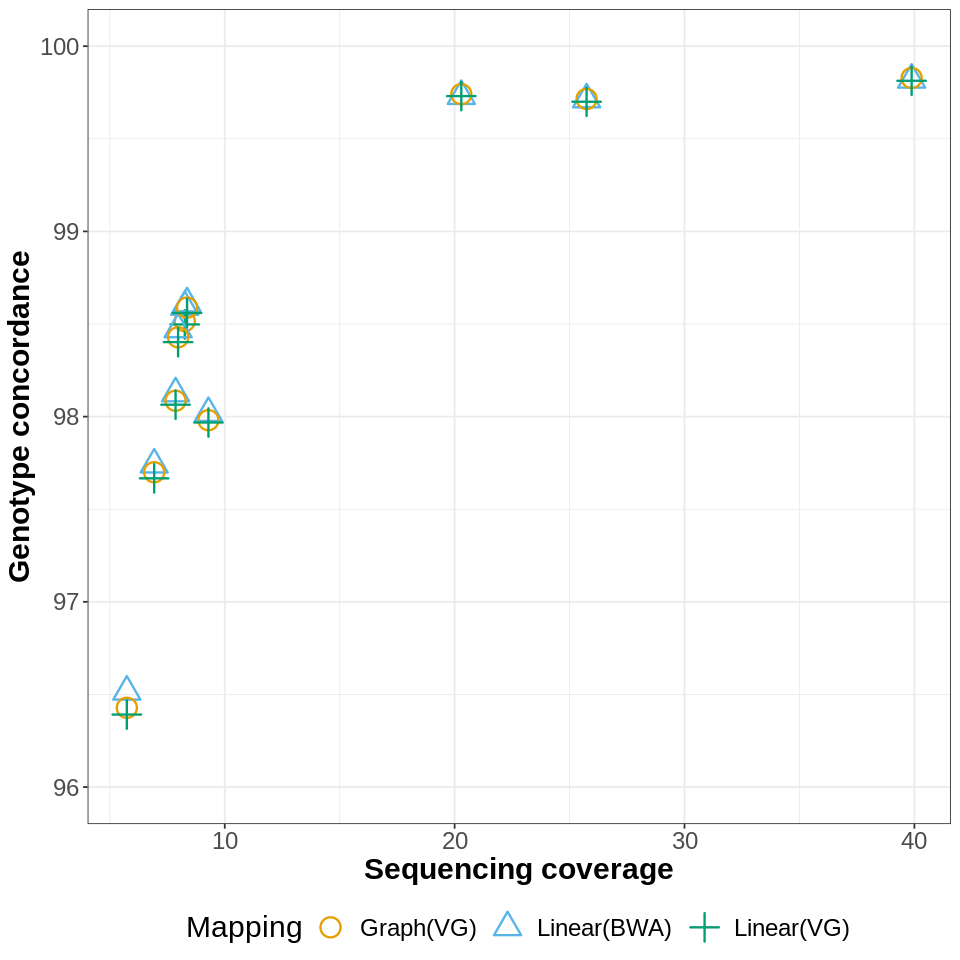

In [0]:
datfil <- datsamall %>% filter(! str_detect(mode,"_fil")) 

datfil %<>% mutate(Mapping=case_when(mode=="bwa"~"Linear(BWA)",
                                     mode=="graph"~"Graph(VG)",
                                     mode=="linear"~"Linear(VG)"))   

ggplot(datfil,aes(x=as.double(as.character(coverage)),y=concor,col=Mapping,shape=Mapping))+
  geom_point(size=5,stroke=1)+
  scale_y_continuous(breaks=seq(90,100,1),limits = c(96,100))+
  scale_colour_manual(values=c("#E69F00", "#56B4E9", "#009E73","red"))+
  scale_shape_manual(values=c(1,2,3))+
  theme_bw()+
  theme(text = element_text(size=18),
        axis.title=element_text(face="bold"),
        legend.position = "bottom")+
  labs(x="Sequencing coverage",y="Genotype concordance")

### Plot relation between precision and recall of the array genotypes

We see no noticeable difference across sequencing coverage. We could also look into the relation between precision-recall in different samples. 

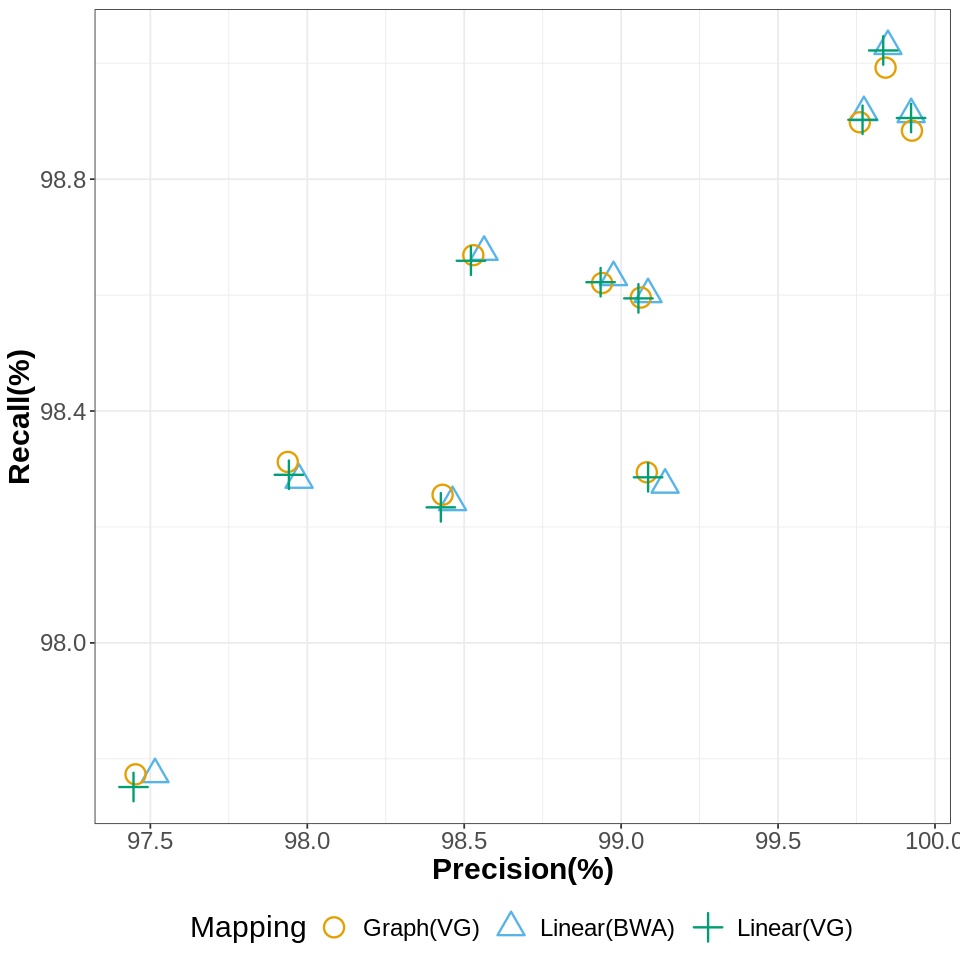

In [0]:
ggplot(datfil,aes(x=precision,y=recal,shape=Mapping,col=Mapping))+
  geom_point(size=5,stroke=1)+
  theme_bw()+
  theme(legend.position = "bottom",
        text = element_text(size=18),
        axis.title=element_text(face="bold"))+
  scale_colour_manual(values=c("#E69F00", "#56B4E9", "#009E73"))+
  scale_shape_manual(values=c(1,2,3))+
  labs(x="Precision(%)",y="Recall(%)")

### Genotyping concordance for variants discovered from GATK and Graphtyper


We additionally discover and genotype variants using GATK and Graphtyper using pipeline we established in our previius paper. We want to see whether we see any difference using different variant callers. 

In [0]:
datgatk  <- read.table(url(file.path(basepath,"gatk4_concordance_all.tsv")),header=TRUE)  %>% select(-prog)
head(datgatk)

,anims,mode,type1,type2,type3,type4,type5,type6,type7,type8,type9,type10,type11,type12,concor,recal,discre,concor_het,concor_alt,precision
,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SAMEA6163185,bwa,155629,61,10,124,187074,118,17,25,201657,134515,1917,2260,99.93483,98.93748,0.09119286,99.95405,99.93657,99.92700
2,SAMEA6163185,bwa_fil,155207,39,8,119,186990,115,17,15,201585,134942,2033,2337,99.94247,98.88839,0.08044477,99.97113,99.93902,99.93159
3,SAMEA6163185,graph,155487,66,8,124,187051,106,19,34,201663,134655,1926,2268,99.93444,98.93316,0.09171016,99.94657,99.94350,99.92725
4,SAMEA6163185,graph-fil,155083,47,7,113,187005,101,18,26,201618,135071,1999,2319,99.94265,98.90161,0.08017807,99.96098,99.94646,99.93366
5,SAMEA6163185,linear,155483,70,10,125,187042,97,17,21,201664,134660,1944,2274,99.93756,98.92705,0.08734862,99.95137,99.94697,99.93316
6,SAMEA6163185,linear-fil,155073,47,9,116,186976,94,17,16,201608,135079,2038,2334,99.94503,98.88788,0.07684759,99.96632,99.94894,99.93750


In [0]:
datgatk %>% group_by(mode) %>% summarise(m_concor=mean(concor),
                                        sd_concor=sd(concor),
                                        m_recall=mean(recal),
                                        sd_recall=sd(recal),
                                        m_discre=mean(discre),
                                        sd_discre=sd(discre),
                                        m_precision=mean(precision),
                                        sd_precision=sd(precision)) %>% as.data.frame()

mode,m_concor,sd_concor,m_recall,sd_recall,m_discre,sd_discre,m_precision,sd_precision
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bwa,97.38208,2.149920,98.23735,0.8730114,3.896332,3.236042,98.94072,0.8041936
bwa_fil,97.38754,2.151166,98.18759,0.8688318,3.886105,3.235640,98.94515,0.8048758
graph,97.25167,2.247525,98.17376,0.9465303,4.091078,3.384535,98.90379,0.8256453
graph-fil,97.25647,2.251548,98.14099,0.9439151,4.081749,3.388030,98.90936,0.8295380
linear,97.24417,2.253610,98.16767,0.9482740,4.102330,3.393733,98.90313,0.8304692
linear-fil,97.25002,2.254821,98.12623,0.9470495,4.091476,3.393296,98.90710,0.8323403


Again we see small difference, even the concordance in graph alignments become slightly lower, when variants called with GATK.

How're about genotypes from Graphtyper?

In [0]:
datgraph  <- read.table(url(file.path(basepath,"graphtyper_concordance_all.tsv")),header=TRUE) 
head(datgraph)

,anims,mode,prog,type1,type2,type3,type4,type5,type6,type7,⋯,type9,type10,type11,type12,concor,recal,precision,discre,concor_het,concor_alt
,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SAMEA6163185,bwa,graphfil,141106,52,34,89,185391,139,19,⋯,194921,149071,3619,8951,99.93330,96.80252,99.93116,0.09134897,99.96387,99.91132
2,SAMEA6163185,bwa,graphtyper,147997,97,59,144,187142,209,20,⋯,201626,142124,1807,2151,99.89578,98.99319,99.89619,0.14372727,99.93165,99.86726
3,SAMEA6163185,graph,graphfil,140676,49,33,83,185336,140,18,⋯,194719,149508,3674,9153,99.93456,96.73715,99.93190,0.08957358,99.96386,99.91123
4,SAMEA6163185,graph,graphtyper,147648,99,58,141,187135,210,21,⋯,201530,142475,1811,2247,99.89551,98.96775,99.89616,0.14402164,99.93005,99.86719
5,SAMEA6163185,linear,graphfil,140695,52,33,86,185293,136,18,⋯,194800,149486,3714,9076,99.93418,96.74656,99.93217,0.09008947,99.96224,99.91332
6,SAMEA6163185,linear,graphtyper,147677,100,58,140,187146,210,20,⋯,201669,142448,1798,2108,99.89554,99.00642,99.89646,0.14396618,99.92898,99.86729


In [0]:
datgraph %>% group_by(mode,prog) %>% summarise(m_concor=mean(concor),
                                        sd_concor=sd(concor),
                                        m_recall=mean(recal),
                                        sd_recall=sd(recal),
                                        m_discre=mean(discre),
                                        sd_discre=sd(discre),
                                        m_precision=mean(precision),
                                        sd_precision=sd(precision)) %>% as.data.frame()

mode,prog,m_concor,sd_concor,m_recall,sd_recall,m_discre,sd_discre,m_precision,sd_precision
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bwa,graphfil,98.64852,0.9932654,96.17519,0.5284266,1.959366,1.450855,98.91410,0.8029828
bwa,graphtyper,98.61036,0.9789897,98.37454,0.5308054,2.028035,1.443737,98.87219,0.7930663
graph,graphfil,98.61082,1.0324405,96.13772,0.5439491,2.013299,1.507299,98.88730,0.8213158
graph,graphtyper,98.57060,1.0154172,98.34499,0.5432636,2.084878,1.496226,98.84439,0.8087539
linear,graphfil,98.61061,1.0323245,96.13143,0.5469498,2.013653,1.507240,98.88890,0.8209154
linear,graphtyper,98.57171,1.0178338,98.36233,0.5526786,2.083212,1.499675,98.84599,0.8106285


Again we also see the same pattern, interestingly we observed that concordance from *Graphtyper* is higher than from *Samtools* or *GATK*.

In [0]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.2.20.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] magrittr_1.5    forcats_0.4.0   stringr_1.4.0   dplyr_0.8.3    
 [5] purrr_0.3.3     readr_1.3.1     tidyr_1.0.0     tibble_2.1.3   
 [9] ggplot2_3.2.1   tidyverse_1.3.0

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-3     tidyselect_0.2.5 repr_1.0.2  